# Simple Regression model with target feature price 

Now that we have a clean dataframe with no multicollinearity, we can attempt to create a simle model first. After we can attempt to create a multi feature model. Again, our target feature is price.

**Main Goals for model fitting:**
* Fit an intial regression model. Using statistical analysis look at the p-value of features and determine which features are important. 
* Test for normality using Jarqu-Bera test. Test for heteroscedasticity. 
* From the tests we can refine and improve our model. 

In [33]:
#import all neccesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

There are 4 main assumptions for regression models: 
1. Linearity 
> There needs to be a linear relationship between the target variable and the predictors being used. 
2. Normality 
> The residual erros from the model are to be assumed as normally distributed. This can be checked using a Qunatile-Quantile Plot. 
3. Homoscedasticity 
> The residual erros from the model should not be correlated with the target variable or any predictors. This can be viewed through a residual plot. The erros must bve random. 

In [34]:
# read cleaned dataframe
clean = pd.read_csv('../data/clean_df.csv', index_col=0)
clean.head()

,price,price_log,sqft_lot,sqft_lot_log,sqft_basement,sqft_above,sqft_above_log,sqft_garage,sqft_patio,bedrooms,...,city_West Tisbury,city_Westport,city_White Center,city_Whitehall,city_Whittier,city_Williston,city_Woodbury,city_Woodinville,city_Yaphank,city_Yarrow Point
21177,248448.0,12.422989,39808,10.591823,0,1790,7.489971,460,290,3,...,0,0,0,0,0,0,0,0,0,0
10844,609000.0,13.319574,12866,9.462343,0,2232,7.710653,440,60,4,...,0,0,0,0,0,0,0,0,0,0
9292,1020000.0,13.835313,15156,9.626152,1380,1380,7.229839,0,0,5,...,0,0,0,0,0,0,0,0,0,0
17878,610000.0,13.321214,15552,9.651945,1210,1210,7.098376,0,330,5,...,0,0,0,0,0,0,0,0,0,0
14450,700000.0,13.458836,8620,9.061840,0,1720,7.450080,0,0,3,...,0,0,0,0,0,0,0,0,0,0


Normalize the clean data by preparing the continuous data. 

In [35]:
for col in clean.columns:
    print(col)

price
price_log
sqft_lot
sqft_lot_log
sqft_basement
sqft_above
sqft_above_log
sqft_garage
sqft_patio
bedrooms
bathrooms
floors
condition_num
extracted_grade_num
waterfront
greenbelt
basement
garage
city
waterfront_1
greenbelt_1
basement_1.0
garage_1.0
city_1035 Bergslien St
city_1040 SE Hawthorne Blvd
city_108 Foothill Blvd
city_1249 Commonwealth Ave
city_1414 Pinehurst Rd
city_15th Ave
city_1710 Belle Isle Blvd
city_17122 W Interstate 10
city_175 W 18th Ave
city_2301 NE Northlake Way
city_34 Ridge Rd
city_35th Ave SW & SW Holden
city_4th Ave
city_721 NW 21st Ave
city_95 Brown St
city_Algona
city_Altoona
city_Ames Lake
city_Anchorage
city_Aneta
city_Ardoch
city_Arlington
city_Asbury Park
city_Auburn
city_Austin
city_Baldwin
city_Baring
city_Bay Shore
city_Beach Haven
city_Beaux Arts
city_Beaver Falls
city_Beaverton
city_Bellevue
city_Berger
city_Billings
city_Bismarck
city_Black Diamond
city_Boise
city_Bothell
city_Bradenton
city_Brentwood
city_Brooklyn
city_Brooksville
city_Burien
cit

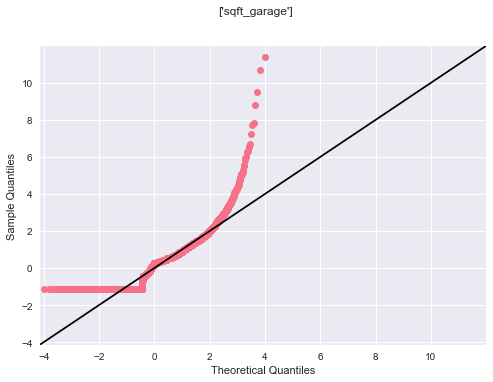

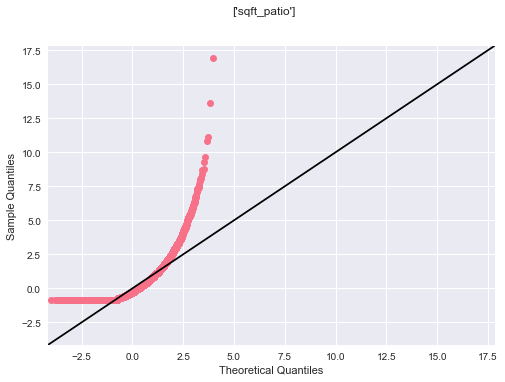

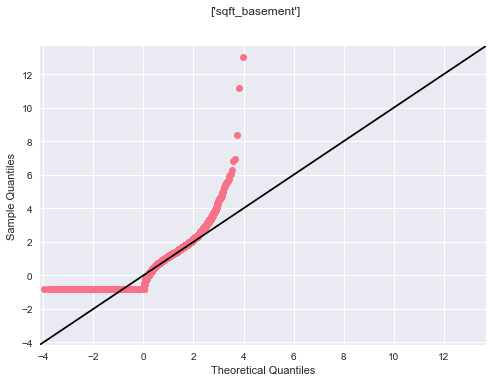

In [36]:
# Create a subset with our continuous variables. 
# We already have a price_log, sqft_lot_log, 
clean_cont = clean[[ 
    'sqft_garage', 'sqft_patio', 'sqft_basement'
]] 

# Define a color palette with different colors for each column
color_palette = sns.color_palette("husl", len(clean_cont))

for i, col in enumerate(clean_cont):
    # View Q-Q plot to view normality of data. 
    # Use qqplot function from StatsModels
    fig, ax = plt.subplots()
    sm.graphics.qqplot(clean_cont[col], dist=stats.norm, line='45', fit=True, ax=ax, color=color_palette[i])
    
    # Customize plot appearance
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(color_palette[i])
    scatter.set_markerfacecolor(color_palette[i])
    line.set_color("black")
    fig.suptitle([col]);

They all can be log transmormed to be closer to normal distribution. 

In [39]:
for col in clean_cont:
    print(col, (clean_cont[col].values == 0).sum())

sqft_garage 9978
sqft_patio 6746
sqft_basement 15434


In [40]:
for col in clean_cont:
    num_nan = clean_cont[col].isna().sum()
    print(f"{col}: {num_nan} NaN values")

sqft_garage: 0 NaN values
sqft_patio: 0 NaN values
sqft_basement: 0 NaN values


We have to consider that not all homes have a basement, garage, or patio. This means a log transfortion would not work properly since log(0) is infinity. We would therefore need to replace zero values with either the mean or median of the columns. Imputing values can impact our results. Maybe we need to consider making a model with homes without a basement, garage, or patio. Treat it as a categorical variable so we can still account for its impact on price and create another model where we drop the rows that are zero and analyze the impact of each feature on the target variable. Create a third model where we dont use dummy variables at all for those features. 

Overall: 
* Model 1 with sqft_garage, sqft_patio, and sqft_basement treated as a categorical variable using dummy variables. Just say home does have those features. 
* Model 2 with sqft_garage, sqft_patio, and sqft_basement considered and drop the rows that are zero and log transform them
* Model 3 without features sqft_garage, sqft_patio, and sqft_basement. Analyze homes without them entirely.